<a href="https://colab.research.google.com/github/sondreid/BAN427/blob/master/ban427_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Exam
## BAN427: Insurance Analytics

### Importing libraries:

In [ ]:
# Modules
import pandas as pd
import os
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier

### Importing excel data

In [ ]:
# Import data from excel to raw_df
raw_df = pd.read_excel("exam_case_data.xlsx")

Adding columns for full churn, partial churn and more sale

In [ ]:
# Adding new columns
raw_df['FULL_CHURN']    = np.where(raw_df['TIME2'] != 2, 1, 0)
raw_df['PARTIAL_CHURN'] = np.where((raw_df['NUMBER_COVERS_TIME2'] - raw_df['NUMBER_COVERS_TIME1']) < 0, 1, 0)
raw_df['MORE_SALE']     = np.where((raw_df['NUMBER_COVERS_TIME2'] - raw_df['NUMBER_COVERS_TIME1']) > 0, 1, 0)


################ Clean data errors in tenure difference #############

df = raw_df[(raw_df['TENURE_TIME2'] - raw_df['TENURE_TIME1'] == 0.5) | (raw_df['TIME2']).isnull()]
df.loc[:,'NUMBER_COVERS_TIME2'] = df.loc[:,'NUMBER_COVERS_TIME2'].fillna(0)
df.loc[:,'TOTAL_PREM_TIME2']    = df.loc[:,'TOTAL_PREM_TIME2'].fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Descriptive Statistics

In [ ]:
#Descriptive statistics 
df = pd.DataFrame(df)
df.FULL_CHURN.astype('category').describe()
df.PARTIAL_CHURN.astype('category').describe()
df.MORE_SALE.astype('category').describe()



#Function for defining age groups
def age_groups(x):
    """'
    Function that outputs  a string denoting an agegroup depending on
    the input integer. 
    """
    if   x < 30:
        return '<30'
    elif x < 40:
        return '<40'
    elif x < 50:
        return '<50'
    elif x < 60:
        return '<60'
    elif x < 70:
        return '<70'
    else:
        return '>=70'

df['AGE_GROUP'] = df['AGE'].apply(age_groups)


### Tables

In [ ]:

#TABLES

#Age table
age_table = df.groupby(by=["AGE_GROUP"]).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]
age_table.style

# Binary variables table
format_table_dict = {'Percentage': '{:.2%}'}
table_binary = pd.DataFrame([[(df.loc[df['FULL_CHURN'] == 1, 'FULL_CHURN']).count(), (df.loc[df['FULL_CHURN'] == 1, 'FULL_CHURN']).count()/len(df)],
                     [(df.loc[df['PARTIAL_CHURN'] == 1, 'PARTIAL_CHURN']).count(), (df.loc[df['PARTIAL_CHURN'] == 1, 'PARTIAL_CHURN']).count()/len(df)],
                     [(df.loc[df['MORE_SALE'] == 1, 'MORE_SALE']).count(), (df.loc[df['MORE_SALE'] == 1, 'MORE_SALE']).count()/len(df)]],
                     index = ['Full churn (Positive)', 'Partial churn (Positive)', 'More sales (Positive)'],
                     columns = ["Count", "Percentage"])

table_binary.style.format(format_table_dict)



,Count,Percentage
Full churn (Positive),4391,7.08%
Partial churn (Positive),8162,13.15%
More sales (Positive),5487,8.84%


In [ ]:
## Number of covers table

table_continous = pd.DataFrame({'Tenure time 1':(df['TENURE_TIME1']).describe()[1:,], 'Tenure time 2':(df['TENURE_TIME2']).describe()[1:,], 
                              'Number of Covers in period 1': (df['NUMBER_COVERS_TIME1']).describe()[1:,],
                              'Number of Covers in period 2': (df['NUMBER_COVERS_TIME2']).describe()[1:,]})

table_continous.style.format('{:.2f}')

,Tenure time 1,Tenure time 2,Number of Covers in period 1,Number of Covers in period 2
mean,8.21,8.92,8.24,7.67
std,8.90,8.95,6.84,6.92
min,0.00,0.50,1.00,0.00
25%,1.60,2.10,3.00,2.00
50%,5.00,5.70,7.00,6.00
75%,12.20,13.00,12.00,12.00
max,42.40,42.90,215.00,219.00


In [ ]:
##  Churn and more sales by the size of portfolio. 


df['PREMIUM_INCREASE'] = np.where((df['TOTAL_PREM_TIME2'] - df['TOTAL_PREM_TIME1']) > 0, 1, 0)

df.groupby(by=["PREMIUM_INCREASE"]).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]


(df['TOTAL_PREM_TIME2'] - df['TOTAL_PREM_TIME1']).describe()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


count    62062.000000
mean      -174.779624
std       1785.179080
min     -38876.000000
25%          0.000000
50%          0.000000
75%        190.000000
max      18977.000000
dtype: float64

In [ ]:
##  Churn and more sales by whether customers has filed a claim
df.groupby(by=['CLAIM_EVENT_BEFORE_TIME1']).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]


df.groupby(by=['AGE_GROUP', 'WOMAN']).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]


df.groupby(by=['WOMAN', 'AGE_GROUP']).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]


FULL_CHURN                           ... MORE_SALE               
                     count      mean       std  min  ...       25%  50%  75%  max
WOMAN AGE_GROUP                                      ...                         
0     <30           2311.0  0.197317  0.398060  0.0  ...       0.0  0.0  0.0  1.0
      <40           5468.0  0.101317  0.301775  0.0  ...       0.0  0.0  0.0  1.0
      <50           7604.0  0.070095  0.255323  0.0  ...       0.0  0.0  0.0  1.0
      <60           8111.0  0.066823  0.249730  0.0  ...       0.0  0.0  0.0  1.0
      <70           6926.0  0.063962  0.244703  0.0  ...       0.0  0.0  0.0  1.0
      >=70          6599.0  0.056675  0.231239  0.0  ...       0.0  0.0  0.0  1.0
1     <30           1834.0  0.135224  0.342055  0.0  ...       0.0  0.0  0.0  1.0
      <40           3585.0  0.080056  0.271417  0.0  ...       0.0  0.0  0.0  1.0
      <50           5091.0  0.052249  0.222551  0.0  ...       0.0  0.0  0.0  1.0
      <60           5329.0  0.043348  0.203658  0.0  ...       0.0  0.0  0.0  1.0
      <70           4195.0  0.045054  0.207447  0.0  ...       0.0  0.0  0.0  1.0
      >=70          5009.0  0.053504  0.225058  0.0  ...       0.0  0.0  0.0  1.0

[12 rows x 24 columns]

## Plots

In [ ]:
sns.set_theme(palette='pastel')
def bar_plot(df, x_var, hue_var, y_var, label_title, x_label, y_label, x_axis_label, y_axis_label):
    """
    Generates a bar plot with hue.
    
    Parameters:
        df: input dataframeø7609
        x_var : x variable
        hue_var: category variable. Is left out if empty string "". 
        y_var: y variable
        label_title: Title of categories
        x_label:

    """ 
    if hue_var == "":
        ax = sns.barplot(data = df,
                x = x_var, 
                y = y_var)
        ax.set_ylabel(y_axis_label)
        ax.set_xlabel(x_axis_label)
    else: 
        ax = sns.barplot(data = df,
                    x = x_var, 
                    y = y_var, 
                    hue = hue_var)
        ax.set_ylabel(y_axis_label)
        ax.set_xlabel(x_axis_label)
        labels = [x_label, y_label]
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, labels, title = label_title)
    return ax


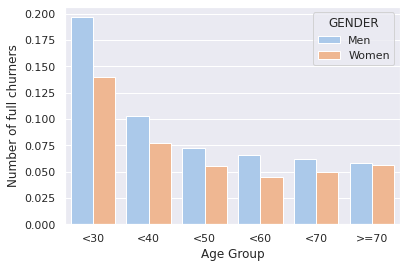

In [ ]:
# FULL CHURNERS
hist_df_full_churn_no_claim = df.loc[df.CLAIM_EVENT_BEFORE_TIME1 == 0,['FULL_CHURN','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_full_churn_no_claim.index.name = 'AGE_GROUP'
hist_df_full_churn_no_claim.reset_index(inplace=True)

bar_plot(hist_df_full_churn_no_claim, "AGE_GROUP", 'WOMAN', 'FULL_CHURN', 'GENDER', 'Men', 'Women', 'Age Group', 'Number of full churners')


<AxesSubplot:xlabel='Claim Event', ylabel='Number of full churners given filed claim'>

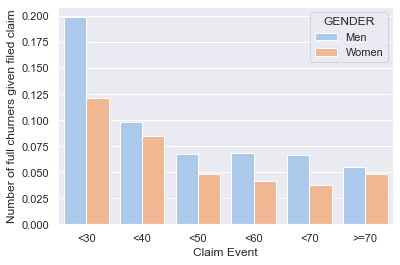

In [ ]:
# FULL CHURNERS given claim
hist_df_full_churn_given_claim = df.loc[df.CLAIM_EVENT_BEFORE_TIME1 == 1,['FULL_CHURN','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_full_churn_given_claim.index.name = 'AGE_GROUP'
hist_df_full_churn_given_claim.reset_index(inplace=True)

bar_plot(hist_df_full_churn_given_claim, "AGE_GROUP", 'WOMAN', 'FULL_CHURN', 'GENDER', 'Men', 'Women', 'Claim Event', 'Number of full churners given filed claim' )


<AxesSubplot:xlabel='Claim Event', ylabel='Number of full churners'>

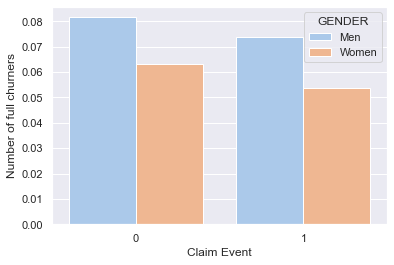

In [ ]:
# FULL CHURN by claim event 
hist_df_full_claim_event = df.loc[:,['FULL_CHURN','CLAIM_EVENT_BEFORE_TIME1', 'WOMAN']].groupby(by = ['CLAIM_EVENT_BEFORE_TIME1', 'WOMAN']).mean()
hist_df_full_claim_event.index.name = 'CLAIM_EVENT_BEFORE_TIME1'
hist_df_full_claim_event.reset_index(inplace=True)

bar_plot(hist_df_full_claim_event, "CLAIM_EVENT_BEFORE_TIME1", 'WOMAN', 'FULL_CHURN', 'GENDER', 'Men', 'Women', 'Claim Event', 'Number of full churners' )


<AxesSubplot:xlabel='Age Group', ylabel='Number of partial churners'>

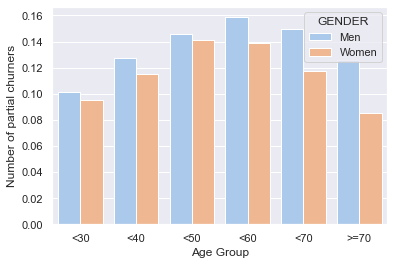

In [ ]:
# PARTIAL CHURNERS
hist_df_partial_churn = df.loc[:,['PARTIAL_CHURN','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_partial_churn.index.name = 'AGE_GROUP'
hist_df_partial_churn.reset_index(inplace=True)

# Partial plot
bar_plot(hist_df_partial_churn, "AGE_GROUP", 'WOMAN', 'PARTIAL_CHURN', 'GENDER', 'Men', 'Women', 'Age Group', 'Number of partial churners' )


<AxesSubplot:xlabel='Age Group', ylabel='Number of increase in coverage'>

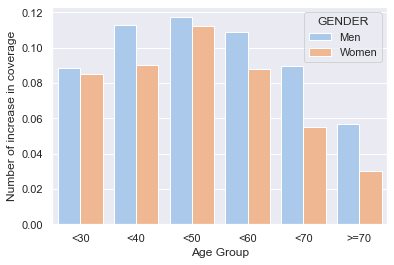

In [ ]:
# MORE SALE
hist_df_more_sale = df.loc[:,['MORE_SALE','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_more_sale.index.name = 'AGE_GROUP'
hist_df_more_sale.reset_index(inplace=True)

# More sales plot
bar_plot(hist_df_more_sale, "AGE_GROUP", 'WOMAN', 'MORE_SALE', 'GENDER', 'Men', 'Women', 'Age Group', 'Number of increase in coverage' )


## Prediction Models

In [ ]:

# Creating features and prediction variables
x   = df.loc[:, ~df.columns.isin(['TIME1', 'NUMBER_COVERS_TIME2', 
'PREMIUM_INCREASE', 'TIME2', 'TOTAL_PREM_TIME2', 'AVERAGE_INCOME_COUNTY_TIME1','TENURE_TIME2','FULL_CHURN', 'PARTIAL_CHURN', 'MORE_SALE'])]


## One hot encoding age group feature
one_hot_encoder = OneHotEncoder(handle_unknown= 'ignore')

one_hot_encoder.fit(df[['AGE_GROUP']])

age_group_hot = one_hot_encoder.transform(df[['AGE_GROUP']]).toarray()
age_group_hot

age_group_hot_df = pd.DataFrame(age_group_hot)
age_group_hot_df.columns = one_hot_encoder.get_feature_names()

# Concat into x
x = pd.concat([x.reset_index(drop=True), age_group_hot_df], axis=1)
x = x.loc[:, x.columns != 'AGE_GROUP'] # Remove string AGE_GROUP

# Check for NaN
x[x.isna().any(axis=1)]


y_full_churn    = df['FULL_CHURN']
y_partial_churn = df['PARTIAL_CHURN']
y_more_sale     = df['MORE_SALE']



def variable_importance(model):
    """"
    Function that takes a fitted model and enumerates its features' importance.
    Prints a barplot
    parameters:
        @model: fitted model
    """
    importance = model.coef_[0]
    for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
    
    pyplot.bar([x for x in range(len(importance))], importance)
    pyplot.show()
    

#ROC-curve function
def roc(ytrain, x_train, ytest, x_test, model):
    """
    Function that draws a ROC curve based o
    Parameters:
        @ytrain: target feature training set
        @x_train: features training set
        @y_test: target feature test set
        @x_test: features test set
        @model: a fitted model
    """
    fit_proba = model.predict_proba(x_train)
    yprob_pred = model.predict_proba(x_test)

    fpr, tpr, tr = metrics.roc_curve(ytest, yprob_pred[:,1])
    auc = metrics.roc_auc_score(ytest, yprob_pred[:, 1])

    fpr1, tpr1, tr = metrics.roc_curve(ytrain, fit_proba[:,1])
    auc1 = metrics.roc_auc_score(ytrain, fit_proba[:,1])

    plt.figure(num = None, figsize = (10,10), dpi = 80)

    plt.plot((1,0), (1,0), ls = "--", c = ".3")
    plt.title = (' ROC Curve - test and train data')
    plt.xlabel('False positive rate')
    plt.plot(fpr, tpr, label = '{} test data (area = {:.2f})'.format(model, auc))
    plt.plot(fpr1, tpr1, label = '{} train data (area = {:.2f})'.format(model, auc1))
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    return plt



In [ ]:
# Splitting the data into train and test [fc = full churn, pc = partial churn, ms = more sales]

xtrain_fc, xtest_fc, ytrain_fc, ytest_fc = train_test_split(x, y_full_churn,    test_size = 0.2, random_state = 0)
xtrain_pc, xtest_pc, ytrain_pc, ytest_pc = train_test_split(x, y_partial_churn, test_size = 0.2, random_state = 0)
xtrain_ms, xtest_ms, ytrain_ms, ytest_ms = train_test_split(x, y_more_sale,     test_size = 0.2, random_state = 0)

In [ ]:
# Scaling the features

sc = StandardScaler()

xtrain_fc = sc.fit_transform(xtrain_fc)
xtest_fc  = sc.transform(xtest_fc)

xtrain_pc = sc.fit_transform(xtrain_pc)
xtest_pc  = sc.transform(xtest_pc)

xtrain_ms = sc.fit_transform(xtrain_ms)
xtest_ms  = sc.transform(xtest_ms)


# Check for Nan
#np.any(np.isnan(xtrain_fc))
#np.any(np.isfinite(xtrain_fc))


### Training the logistic regression model

In [ ]:


logreg_fc = LogisticRegression(random_state = 0)
logreg_fc.fit(xtrain_fc, ytrain_fc)

logreg_pc = LogisticRegression(random_state = 0)
logreg_pc.fit(xtrain_pc, ytrain_pc)

logreg_ms = LogisticRegression(random_state = 0)
logreg_ms.fit(xtrain_ms, ytrain_ms)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Predicting the logreg model
ypred_logreg_fc = logreg_fc.predict(xtest_fc)
yprob_logreg_fc = (logreg_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)

ypred_logreg_pc = logreg_pc.predict(xtest_pc)
yprob_logreg_pc = (logreg_pc.predict_proba(xtest_pc)[:,1]  >= 0.05).astype(bool)

ypred_logreg_ms = logreg_ms.predict(xtest_ms)
yprob_logreg_ms = (logreg_pc.predict_proba(xtest_ms)[:,1]  >= 0.05).astype(bool)



Feature: 0, Score: -0.39742
Feature: 1, Score: 0.28328
Feature: 2, Score: -0.19321
Feature: 3, Score: -0.54978
Feature: 4, Score: 0.31932
Feature: 5, Score: 0.08064
Feature: 6, Score: -0.18965
Feature: 7, Score: 0.08006
Feature: 8, Score: -0.16694
Feature: 9, Score: 0.10476
Feature: 10, Score: -0.18109
Feature: 11, Score: 0.25441
Feature: 12, Score: 0.17188
Feature: 13, Score: 0.03359
Feature: 14, Score: -0.05086
Feature: 15, Score: -0.09762
Feature: 16, Score: -0.20363


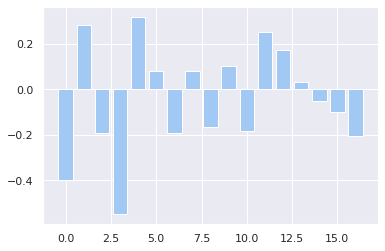

[[4402 6349]
 [ 130 1532]]
[[4707 6835]
 [ 182  689]]
[[4296 6996]
 [ 236  885]]


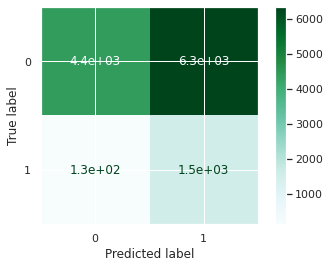

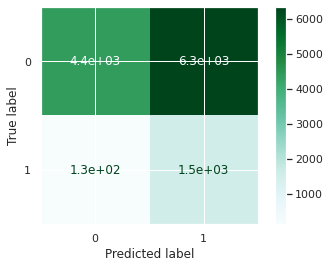

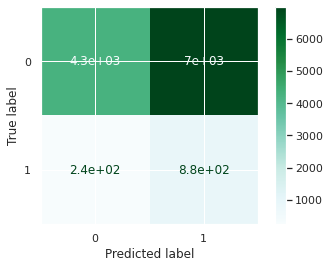

In [ ]:
# Variable importance  
#FC 
variable_importance(logreg_fc)
cm_pc = confusion_matrix(ytest_pc, yprob_logreg_pc)
print(cm_pc)
accuracy_score(ytest_pc, yprob_logreg_pc)
cmd_pc = ConfusionMatrixDisplay(cm_pc, display_labels=['0','1'])
cmd_pc.plot(cmap='BuGn')
cm_fc = confusion_matrix(ytest_fc, yprob_logreg_fc)
print(cm_fc)
accuracy_score(ytest_fc, yprob_logreg_fc)
cmd_fc = ConfusionMatrixDisplay(cm_pc, display_labels=['0','1'])
cmd_fc.plot(cmap='BuGn')



cm_ms = confusion_matrix(ytest_ms, yprob_logreg_ms)
print(cm_ms)
accuracy_score(ytest_ms, yprob_logreg_ms)
cmd_ms = ConfusionMatrixDisplay(cm_ms, display_labels=['0','1'])
cmd_ms.plot(cmap='BuGn')

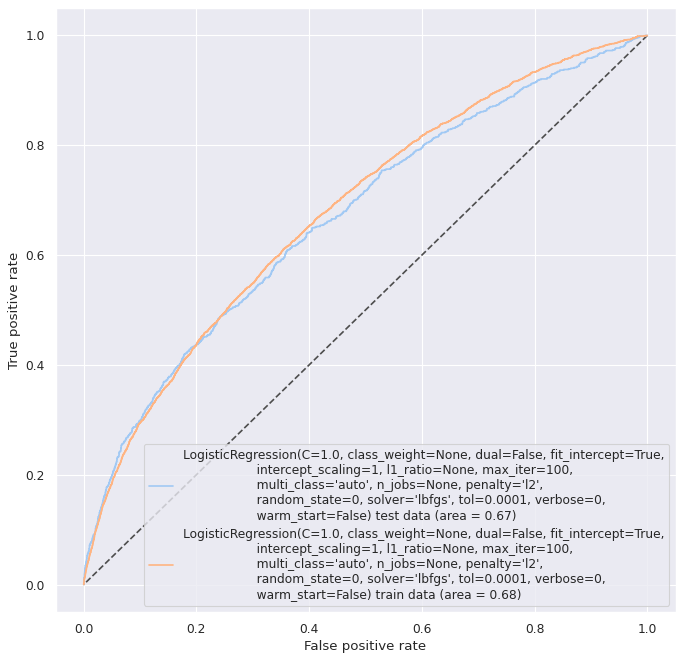

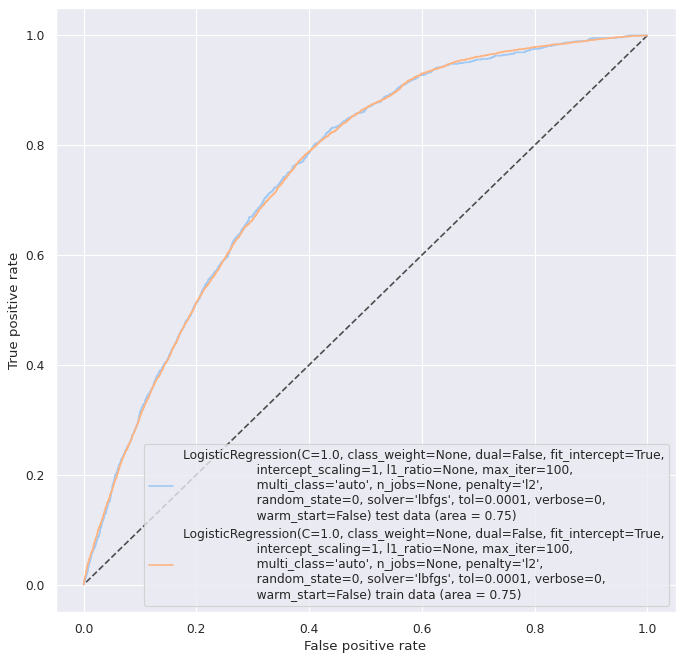

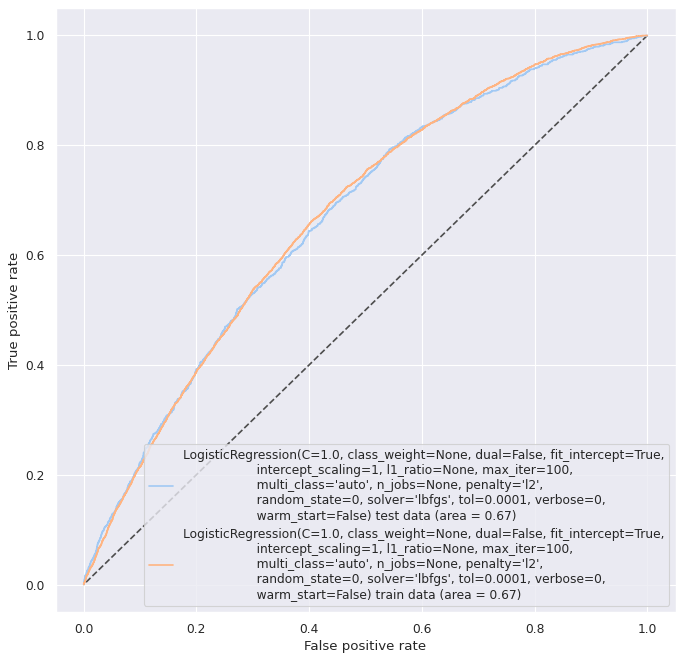

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
# ROC curve logreg y

roc_logreg_fc = roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, logreg_fc)
roc_logreg_fc

roc_logreg_pc = roc(ytrain_pc, xtrain_pc, ytest_pc, xtest_pc, logreg_pc)
roc_logreg_pc

roc_logreg_ms = roc(ytrain_ms, xtrain_ms, ytest_ms, xtest_ms, logreg_ms)
roc_logreg_ms


### Training the KNN-model

In [ ]:

knn_fc = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_fc.fit(xtrain_fc, ytrain_fc)

knn_pc = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_pc.fit(xtrain_pc, ytrain_pc)

knn_ms = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_ms.fit(xtrain_ms, ytrain_ms)

# Predicting the knn models
ypred_knn_fc = knn_fc.predict(xtest_fc)

ypred_knn_pc = knn_pc.predict(xtest_pc)

ypred_knn_ms = knn_ms.predict(xtest_ms)


[[11435   107]
 [  846    25]]
[[10341   410]
 [ 1483   179]]
[[11152   140]
 [ 1100    21]]


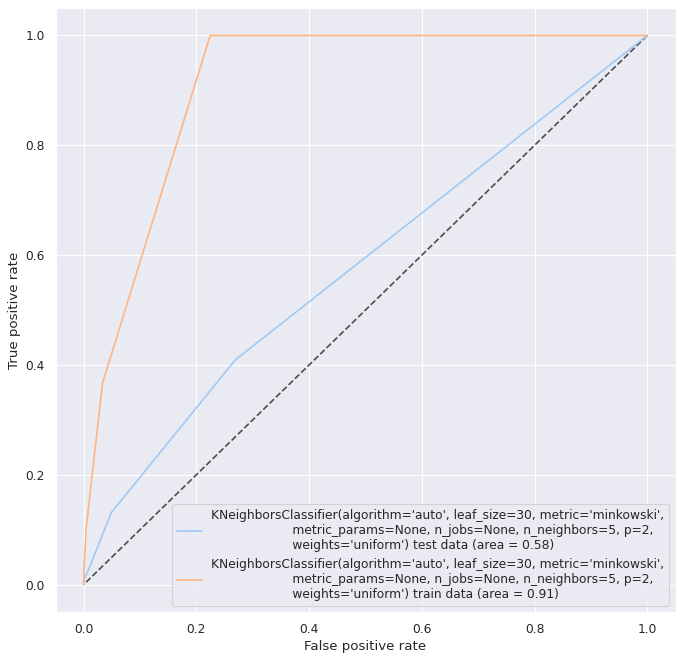

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
# Checking the accuracy with confusion matrix
cm_knn_fc = confusion_matrix(ytest_fc, ypred_knn_fc)
print(cm_knn_fc)
accuracy_score(ytest_fc, ypred_knn_fc)


tn, fp, fn, tp = confusion_matrix(ytest_fc, ypred_knn_fc).ravel()
(tn, fp, fn, tp)


cm_knn_pc = confusion_matrix(ytest_pc, ypred_knn_pc)
print(cm_knn_pc)
accuracy_score(ytest_pc, ypred_knn_pc)


cm_knn_ms = confusion_matrix(ytest_ms, ypred_knn_ms)
print(cm_knn_ms)
accuracy_score(ytest_ms, ypred_knn_ms)


### ROC-curve KNN ###

roc_KNN_fc = roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, knn_fc)
roc_KNN_fc


### Training the SVM-model

In [ ]:


svc_fc = SVC(kernel = 'linear', random_state = 0, probability = True)
svc_fc.fit(xtrain_fc, ytrain_fc)

svc_pc = SVC(kernel = 'linear', random_state = 0, probability = True)
svc_pc.fit(xtrain_pc, ytrain_pc)

svc_ms = SVC(kernel = 'linear', random_state = 0, probability = True)
svc_ms.fit(xtrain_ms, ytrain_ms)

# Predicting the svm model
ypred_svc_fc = (svc_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)
ypred_svc_pc = (svc_pc.predict_proba(xtest_pc)[:,1]  >= 0.05).astype(bool)
ypred_svc_ms = (svc_ms.predict_proba(xtest_ms)[:,1]  >= 0.05).astype(bool)

In [ ]:
# Checking the accuracy with confusion matrix
cm_svc_fc = confusion_matrix(ytest_fc, ypred_svc_fc)
print(cm_svc_fc)
accuracy_score(ytest_fc, ypred_svc_fc)

cm_svc_pc = confusion_matrix(ytest_pc, ypred_svc_pc)
print(cm_svc_pc)
accuracy_score(ytest_pc, ypred_svc_pc)

cm_svc_ms = confusion_matrix(ytest_ms, ypred_svc_ms)
print(cm_svc_ms)
accuracy_score(ytest_ms, ypred_svc_ms)


In [ ]:
#ROC Curve SVM
roc_SVM_fc = roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, svc_fc)
roc_SVM_fc

roc_SVM_pc = roc(ytrain_pc, ytest_pc, ypred_svc_pc)
roc_SVM_pc

roc_SVM_ms = roc(ytrain_ms, ytest_ms, ypred_svc_ms)
roc_SVM_ms


In [ ]:
#Training the Naive bayes-model

nb_fc = GaussianNB
nb_fc.fit(xtrain_fc, ytrain_fc)



### SVM-model with 'AVERAGE_INCOME_COUNTY_TIME1

In [ ]:

df_avg_income = df[df['AVERAGE_INCOME_COUNTY_TIME1'].notna()]

y_full_churn_avg_income   = df_avg_income['FULL_CHURN']
xtrain_avg_income, xtest_avg_income, ytrain_avg_income, ytest_avg_income = train_test_split(x_avg_income, y_full_churn_avg_income, test_size = 0.2, random_state = 0)

svc_fc = SVC(kernel = 'linear', random_state = 0, probability = True)
svc_fc.fit(xtrain_avg_income, ytrain_avg_income)

# Predicting the svm model
ypred_svc_avg_income = (svc_fc.predict_proba(xtest_avg_income)[:,1]  >= 0.05).astype(bool)

# Checking the accuracy with confusion matrix
cm_svc_avg_income = confusion_matrix(ytest_avg_income, ypred_svc_avg_income)
print(cm_svc_avg_income)
accuracy_score(ytest_avg_income, ypred_svc_avg_income)


### Traning the Random Forest model

In [ ]:

rfc_fc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc_fc = rfc_fc.fit(xtrain_fc, ytrain_fc)

# Prediction
ypred_rfc_fc = (rfc_fc.predict_proba(xtest_fc)[:,1] > 0.2).astype(bool)

# Accuracy
cm_rfc_fc = confusion_matrix(ytest_fc, ypred_rfc_fc)
print(cm_rfc_fc)
recall_score(ytest_fc, ypred_rfc_fc)


In [ ]:
def test_treshold(model, n, x_test, y_test):
    """ 
    parameters:
        @model: fitted model
    """  
    best_score = 0
    best_treshold = 0
    for i in range(n):
        print(i/n)
        treshold = i/n 
        print(best_score)
        y_preds = (model.predict_proba(x_test)[:,1] >= treshold).astype(bool)
        accuracy_test = recall_score(y_test, y_preds)
        if accuracy_test > best_score:
            best_score = accuracy_test
            best_treshold = treshold

    return best_treshold, best_score

test_treshold(rfc_fc, 100, xtest_fc, ytest_fc)
## Alternative treshold tester

fpr, trp, tresholds = metrics.roc_curve()


gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


NameError: ignored